In [1]:
import os, sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Activation, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.applications import RegNetY004
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split

physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
mixed_precision.set_global_policy('mixed_float16')
print(f'Running on Python {sys.version}, Tensorflow {tf.__version__}.')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti, compute capability 8.6
Running on Python 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)], Tensorflow 2.10.0.


In [6]:
import os
import cv2
import imghdr

def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'Dataset'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range(len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  without_mask
processing class directory  with_mask
 no improper image files were found


In [2]:
# data loading config
batch_size = 192
img_height = 224
img_width = 224
dataPath = 'Dataset'
labels = 'inferred'
label_mode = 'categorical'  # one hot encoding
color_mode = 'rgb'
shuffle = True
seed = 69
test_split = 0.2  # split into train and test (NOT val), 0-1
AUTOTUNE = tf.data.AUTOTUNE

# NOT USING GENERATOR
# ImageGen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")
# train = tf.keras.preprocessing.image_dataset_from_directory(dataPath, labels=labels, label_mode=label_mode,
# color_mode=color_mode, shuffle=shuffle, subset="training", seed=seed, validation_split=test_split,
# image_size=(img_height, img_width), batch_size=batch_size)

train = tf.keras.preprocessing.image_dataset_from_directory(dataPath, labels=labels, label_mode=label_mode,
color_mode=color_mode, shuffle=shuffle, seed=seed,
image_size=(img_height, img_width), batch_size=batch_size)
train_class_names = train.class_names

# val = tf.keras.preprocessing.image_dataset_from_directory(dataPath, labels=labels, label_mode=label_mode,
# color_mode=color_mode, shuffle=shuffle, subset="validation", seed=seed, validation_split=test_split,
# image_size=(img_height, img_width), batch_size=batch_size)

train = train.cache().prefetch(buffer_size=AUTOTUNE)
# val = val.cache().prefetch(buffer_size=AUTOTUNE)

Found 22309 files belonging to 2 classes.


In [3]:
# mobile_net_v2 = MobileNetV2(weights="imagenet", alpha=1.0, input_shape=(img_height, img_width, 3), include_top=False)
# mobile_net_v2.trainable = True
# mobile_net_v3 = MobileNetV3Small(weights="imagenet", alpha=1.0, input_shape=(img_height, img_width, 3), include_top=False)
# mobile_net_v3.trainable = True
regnet = RegNetY004(weights="imagenet", input_shape=(img_height, img_width, 3), include_top=False)

xInput = Input((img_height, img_width, 3))
x = regnet(xInput)
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten()(x)
x = Dense(128, activation='swish')(x)
x = Dropout(0.2)(x)
xOutput = Dense(2)(x)  # no activation as using logit

model = Model(xInput, xOutput)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 regnety004 (Functional)     (None, 7, 7, 440)         3930296   
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 440)        0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 440)               0         
                                                                 
 dense (Dense)               (None, 128)               56448     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

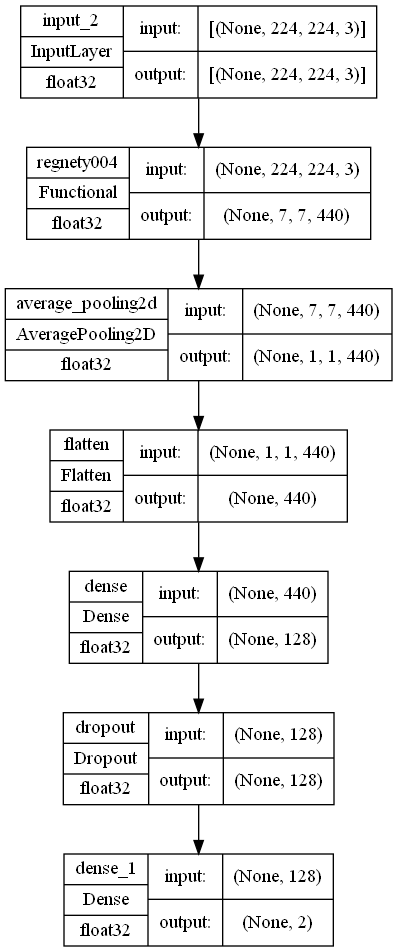

In [4]:
opt = keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-8)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
reg = keras.regularizers.L2(1e-5)
epoch = 100
metrics = ['accuracy']
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=1,
                                     mode='auto', baseline=None, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('./best_model',monitor='val_accuracy',save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=1, verbose=1)]
model.compile(optimizer=opt, loss=loss, metrics=metrics)
model.summary()
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, to_file='regnet.png')

In [5]:
history = model.fit(train, epochs=epoch, callbacks=callbacks, verbose=1, use_multiprocessing=True)

Epoch 1/100
117/117 [==============================] - 55s 141ms/step - loss: 0.2430 - accuracy: 0.9831 - lr: 0.0010
Epoch 2/100
117/117 [==============================] - 30s 261ms/step - loss: 0.2028 - accuracy: 0.9996 - lr: 0.0010
Epoch 3/100
117/117 [==============================] - 10s 83ms/step - loss: 0.2009 - accuracy: 0.9999 - lr: 0.0010
Epoch 4/100
117/117 [==============================] - 10s 82ms/step - loss: 0.2004 - accuracy: 0.9999 - lr: 0.0010
Epoch 5/100
117/117 [==============================] - 10s 81ms/step - loss: 0.2001 - accuracy: 1.0000 - lr: 0.0010
Epoch 6/100
117/117 [==============================] - 9s 81ms/step - loss: 0.1999 - accuracy: 1.0000 - lr: 0.0010
Epoch 7/100
117/117 [==============================] - 9s 81ms/step - loss: 0.1998 - accuracy: 1.0000 - lr: 0.0010
Epoch 8/100
117/117 [==============================] - 9s 81ms/step - loss: 0.1998 - accuracy: 1.0000 - lr: 0.0010
Epoch 9/100
  4/117 [>.............................] - ETA: 9s - loss: 0.

KeyboardInterrupt: 

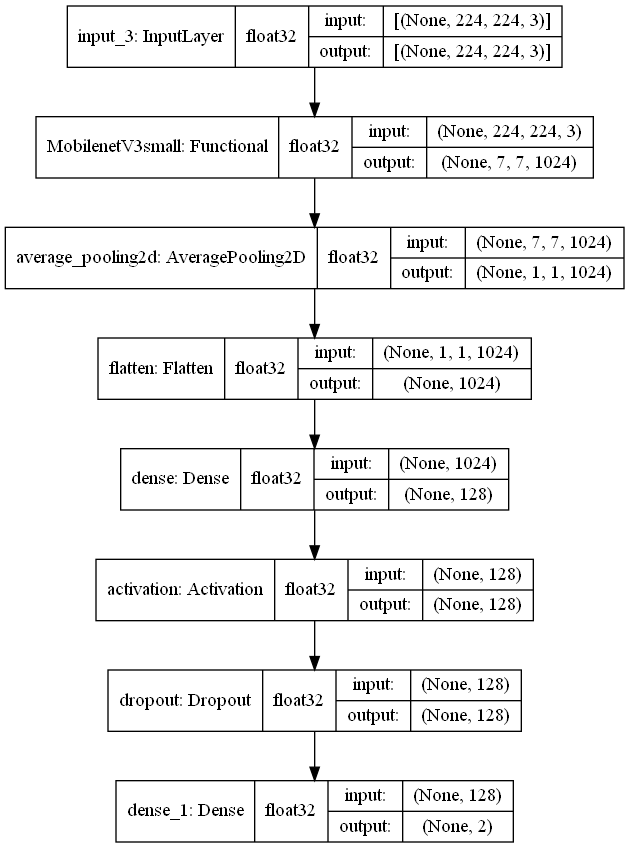

In [11]:
# model = load_model('MobileNetV3 mask')
# model.predict(test_x[0])
# test_y[0]

In [6]:
# model = load_model('best_model')
# model.evaluate(data, labels)
model.save('regnety004_full')
'''
MobileNet V3 full train: 99.76
MobileNet V2 full train no preprocess: 99.58
MobileNet V2 full train with preprocess: 99.85
'''

INFO:tensorflow:Assets written to: regnety004_full\assets


INFO:tensorflow:Assets written to: regnety004_full\assets


'\nMobileNet V3 full train: 99.76\nMobileNet V2 full train no preprocess: 99.58\nMobileNet V2 full train with preprocess: 99.85\n'